# Notebook to do Duch-lab-style plotting of relative MN spike phase

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import glob
import pickle
# import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.signal import find_peaks, hilbert
from scipy.spatial.distance import cdist
from scipy.stats import median_abs_deviation

from sklearn.cluster import KMeans

from neo.io import Spike2IO

# from matplotlib import rcParams
from mosquito.process_abf import (load_processed_data, cluster_spikes, save_processed_data, detect_spikes, estimate_spike_rate, 
                                   detrend_emg, filter_emg)
from mosquito.util import set_plot_params, my_adjust_axes, my_add_scalebar

## Params

In [3]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
plt.rc('ytick', labelsize=14)    # fontsize for y tick labels


## Helper functions

In [6]:
def get_pairwise_phase(spike_times, spike_times_ref):
    """
    For two arrays of spike times (spike_times and spike_times_ref), determine the phase of 
    spike_times relative to the spike_times_ref. 

    Here, phase is in [0, 1]
    
    """
    # initialize some storage
    phases = list()

    # loop over spikes in x
    for spike_time in spike_times:
        # find the events in spike_times_ref bracketing current spike
        spike_times_ref_pre = spike_times_ref[spike_times_ref <= spike_time]
        spike_times_ref_post = spike_times_ref[spike_times_ref > spike_time]

        # check that we have bracketing events
        if (spike_times_ref_pre.size == 0) or (spike_times_ref_post.size == 0):
            phase = np.nan
        else:
            # if we have ref events on either side, get phase
            spike_time_ref_pre = spike_times_ref_pre[-1]
            spike_time_ref_post = spike_times_ref_post[0]
            phase = (spike_time - spike_time_ref_pre)/(spike_time_ref_post - spike_time_ref_pre)

        # add to list
        phases.append(phase)
        
    # return as array
    return np.asarray(phases)
    

In [7]:
def plot_spike_raster(spike_times_list, ax=None, xlim=None,colors=['r', 'y', 'orange', 'chocolate'], labels=None):
    """
    Given a list containing multiple arrays of spike times, plot the spike times as a raster

    """
    # make sure we have an axis object
    if ax is None:
        fig, ax = plt.subplots()

    # get extent of raster lines on y-axis 
    line_boundaries = np.linspace(0, 1, len(spike_times_all) + 1)
    boundary_ctrs = (line_boundaries[:-1] + line_boundaries[1:])/2.0


    # loop over spike time lists
    for ith, spike_times in enumerate(spike_times_list):
        # current boundaries for raster lines
        ymin = line_boundaries[ith+1]
        ymax = line_boundaries[ith]

        spike_times_curr = spike_times.copy()
        if xlim is not None:
            spike_times_curr =  spike_times_curr[(spike_times_curr >= xlim[0]) & (spike_times_curr <= xlim[1])]
       
            
        # loop over spikes
        for st in spike_times:
            ax.axvline(st, ymin=ymin, ymax=ymax, color=colors[ith])

    # set labels if we have them
    if labels is not None:
        ax.set_yticks(boundary_ctrs, labels=labels)

    # set x (time) limits if we have them
    if xlim is not None:
        ax.set_xlim(xlim)
        
    return ax
    

## Load data

In [36]:
# single data file to start
data_folder = 63  # 66 # 65
axo_num = 7  # 1  # 4

data = load_processed_data(data_folder, axo_num, data_suffix='_processed_sort')


In [44]:
# read out fields and get sorted units
t = data['time']
if 'sorted_units' in data.keys():
    spike_idx_list = data['sorted_units']
    spike_times_ref = t[spike_idx_list[0][0]]
    spike_times = t[spike_idx_list[1][0]]
else:
    spike_idx = data['spike_idx']
    spike_times_ref = t[spike_idx[0]]
    spike_times = t[spike_idx[1]]

In [45]:
# calculate phases
phases = get_pairwise_phase(spike_times, spike_times_ref)

# makes phases -pi to pi
phases *= 2*np.pi
phases[phases > np.pi] -= 2*np.pi


Text(0.5, 1.0, 'relative phase')

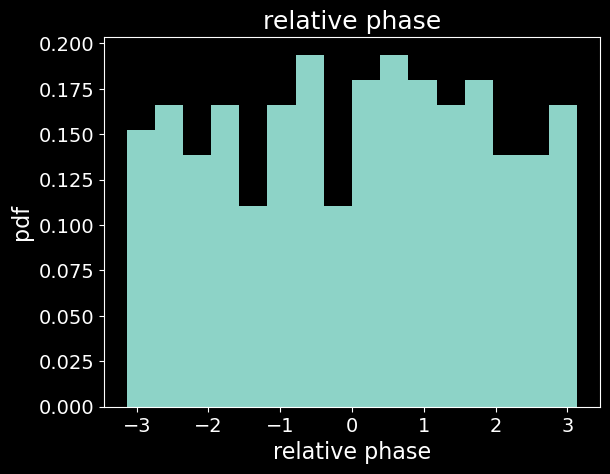

In [46]:
# make histogram of phases
fig, ax = plt.subplots()

bins = np.linspace(-np.pi, np.pi, 17)

ax.hist(phases, bins, density=True)

ax.set_xlabel('relative phase')
ax.set_ylabel('pdf')
ax.set_title(f'relative phase')